# **FactoryIQ: ML-Driven Supplier Defect Impact Predictor**

<div style="text-align:center;">
  <img src="https://cdnl.iconscout.com/lottie/premium/thumb/auto-factory-workers-supervising-assembling-motor-vehicles-13456218-10901100.gif" width="68%">
</div>


# Project Objective
To develop a machine learning solution that predicts the total downtime (in minutes) arising from supplier-related quality defects at manufacturing plants. The project aims to provide actionable insights for minimizing operational losses, guiding resource allocation, and informing supplier quality management across a multi-plant manufacturing network.

## Business Problem
Supplier defects lead to unplanned production downtime in manufacturing plants, incurring substantial costs and disrupting delivery schedules. The company operates multiple plants in different locations, each producing various categories of products and sourcing materials from a diverse supplier base. Despite ongoing efforts, downtime caused by quality defects remains unpredictable and unevenly distributed across plants and product categories. Business leaders need to:

- Pinpoint which plant locations and product categories experience the highest downtime due to supplier defects
- Proactively plan interventions and allocate quality assurance resources to locations and products at greatest risk
- Enhance supplier vetting and development programs based on data-driven downtime risk assessments



---



### **Importing libraries**

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from xgboost import XGBRegressor
import statsmodels.api as sm

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, silhouette_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Set plotting styles for better visuals
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (8, 4)

In [8]:
from warnings import filterwarnings
filterwarnings('ignore')

In [11]:
## Use this code block when executing this ipynb file in google colab.
# from google.colab import files
# uploaded = files.upload()

# import io
# df = pd.read_excel(io.BytesIO(uploaded['Economy-Supplier_Quality_Analysis_Dataset.xlsx']))

In [13]:
df = pd.read_excel('Economy-Supplier_Quality_Analysis_Dataset.xlsx')

In [14]:
# making a dataframe copy
batches = df.copy()

In [15]:
# display first 5 rows
batches.head()

,Date,Vendor,Plant Location,State,Category,Material Type,Defect Type,Defect,Total Defect Qty,Total Downtime Minutes
0,2013-04-13,Gabvine,Reading,MN,Logistics,Film,Impact,Damaged Secondary Packaging,326975.0,3252.0
1,2014-03-12,Linkbridge,Prescott,NY,Packaging,Film,No Impact,Foreign Material,NaN,2337.0
2,2013-09-28,Realpoint,Florence,IL,Mechanicals,Raw Materials,No Impact,Foreign objects found,82253.0,828.0
3,2013-04-17,Latz,Westside,NC,Logistics,Corrugate,Impact,Gap Variation,189966.0,1935.0
4,2013-03-13,Skiptube,Bruce Crossing,NJ,Goods & Services,Controllers,Rejected,Gap Variation,103577.0,1111.0


In [16]:
# last 5 rows
batches.tail()

,Date,Vendor,Plant Location,State,Category,Material Type,Defect Type,Defect,Total Defect Qty,Total Downtime Minutes
9995,2014-01-24,Bubblebox,Frazer,MT,Mechanicals,Corrugate,No Impact,Cracked,999759.0,5000.0
9996,2014-09-09,Brainbox,Riverside,MN,Logistics,Corrugate,Rejected,Incorrect Labeling,486620.0,4919.0
9997,2014-04-28,Demivee,New Britain,OH,Logistics,Raw Materials,Rejected,Warped,444030.0,4510.0
9998,2013-05-27,Eamia,Frazer,OR,Mechanicals,Film,Rejected,Wrong Fasteners,726718.0,5000.0
9999,2013-10-06,Feedfire,June Lake,NY,Mechanicals,Corrugate,Impact,String Defects,959926.0,5000.0


In [17]:
# checking info
batches.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Date                    10000 non-null  datetime64[ns]
 1   Vendor                  10000 non-null  object        
 2   Plant Location          10000 non-null  object        
 3   State                   10000 non-null  object        
 4   Category                10000 non-null  object        
 5   Material Type           10000 non-null  object        
 6   Defect Type             10000 non-null  object        
 7   Defect                  10000 non-null  object        
 8   Total Defect Qty        9589 non-null   float64       
 9   Total Downtime Minutes  9604 non-null   float64       
dtypes: datetime64[ns](1), float64(2), object(7)
memory usage: 781.4+ KB


In [18]:
# checking null values
batches.isnull().sum()

Date                        0
Vendor                      0
Plant Location              0
State                       0
Category                    0
Material Type               0
Defect Type                 0
Defect                      0
Total Defect Qty          411
Total Downtime Minutes    396
dtype: int64

In [19]:
# shape of the df
print(f"Total rows are {batches.shape[0]} and Total columns are {batches.shape[1]}")

Total rows are 10000 and Total columns are 10


In [20]:
# Descriptive stats
batches.describe()

,Date,Total Defect Qty,Total Downtime Minutes
count,10000,9589.000000,9604.000000
mean,2014-01-01 01:59:39.840000,458852.493378,3358.459496
min,2013-01-01 00:00:00,5427.000000,86.000000
25%,2013-07-01 00:00:00,181533.000000,1843.000000
50%,2014-01-02 00:00:00,360887.000000,3627.000000
75%,2014-07-04 00:00:00,729132.000000,5000.000000
max,2014-12-30 00:00:00,999759.000000,5000.000000
std,NaN,326047.803718,1612.121097


#### Inferences from the Descriptive Statistics
Total Defect Qty:
- Ranges widely (5,427 to 999,759) and is highly variable.
- Right-skewed: most values are lower, but some very high, pulling up the mean.

Total Downtime Minutes:
- Also widely spread (86 to 5,000).
- Many records are capped at 5,000 minutes, possibly due to a business or synthetic data limit.

Data Quality:
- Some missing values exist, which should be imputed (median is recommended).

Implication:
- The data shows real-world-like variability and operational diversity, but frequent capping at 5,000 may affect extreme value modeling.

\

**Conclusion:**
Review the 5,000-minute cap, use median imputation for missing values, and be aware that predictions may be influenced by the high frequency of large downtime events.


In [21]:
# Descriptive stats of category features
batches.describe(include='object')

,Vendor,Plant Location,State,Category,Material Type,Defect Type,Defect
count,10000,10000,10000,10000,10000,10000,10000
unique,318,30,21,6,22,3,263
top,Feedfire,Riverside,MI,Mechanicals,Raw Materials,No Impact,Not Certified
freq,58,399,1787,3061,2925,3978,624


#### Inferences

- All columns have 10,000 entries, confirming data completeness for these fields.
- The dataset is diverse—especially for Vendor and Defect, with many unique values.
- Some columns are highly imbalanced, e.g., "Mechanicals" and "Raw Materials" dominate their categories.

This summary informs which features are high-cardinality (requiring careful encoding)

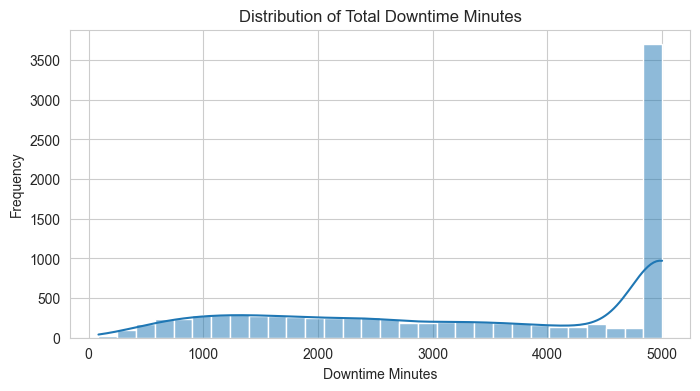

In [22]:
sns.histplot(batches['Total Downtime Minutes'], bins=30, kde=True)
plt.title('Distribution of Total Downtime Minutes')
plt.xlabel('Downtime Minutes')
plt.ylabel('Frequency')
plt.show()

- Most downtime events are short, but there is a pronounced spike at the maximum (5,000 minutes), suggesting a cap or limit in the data.
- The distribution is right-skewed with many minor incidents and a concentration of extreme values at the high end, reflecting real-world operational unpredictability and possible reporting or business limits.

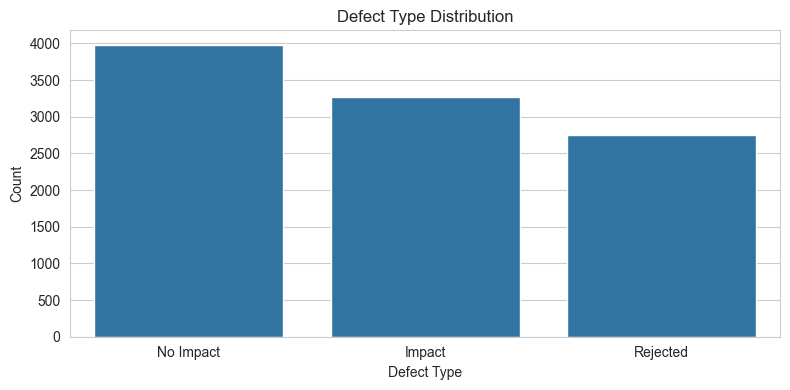

In [23]:
sns.countplot(data=batches, x='Defect Type', order=batches['Defect Type'].value_counts().index)
plt.title('Defect Type Distribution')
plt.xlabel('Defect Type')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

- Most defects are "No Impact": These are common but don’t affect product performance.
- Serious defects ("Impact" and "Rejected") are less frequent but should receive special focus to avoid business risks.
- Action: Strengthen controls for severe defects while maintaining monitoring for all defect types. Optimize resource allocation based on defect severity.

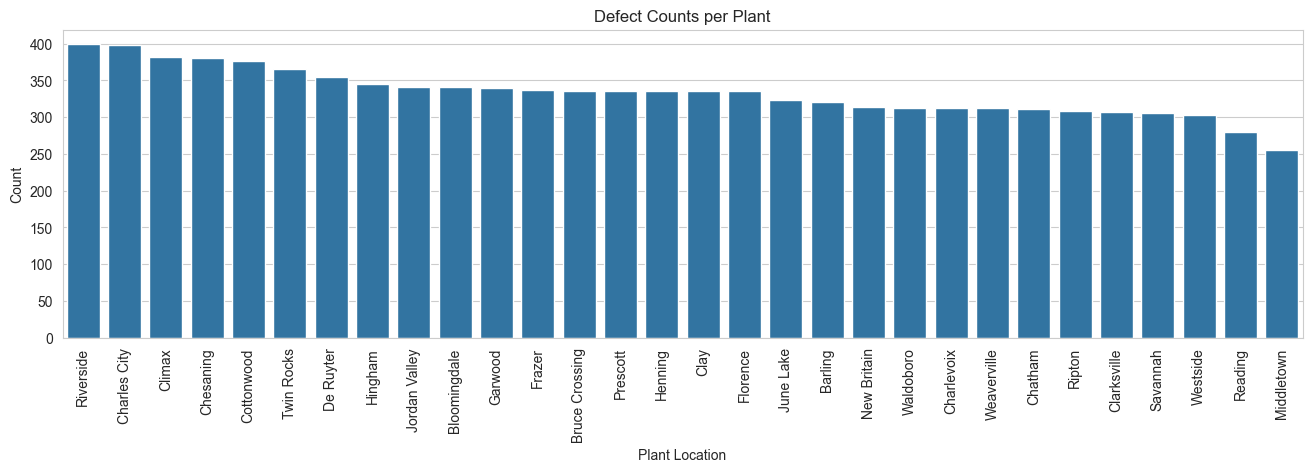

In [24]:
plt.figure(figsize=(16, 4))
sns.countplot(data=batches, x='Plant Location', order=batches['Plant Location'].value_counts().index)
plt.title('Defect Counts per Plant')
plt.xlabel('Plant Location')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

- Defects are high across all plants: Quality issues are widespread, not limited to a few locations.
- Top plants (like Riverside, Charles City, Twin Rocks) have the most defects: These should be prioritized for immediate improvement.
- Business action: Focus on system-wide process improvements and target the highest-count plants first for root cause analysis and quick wins.

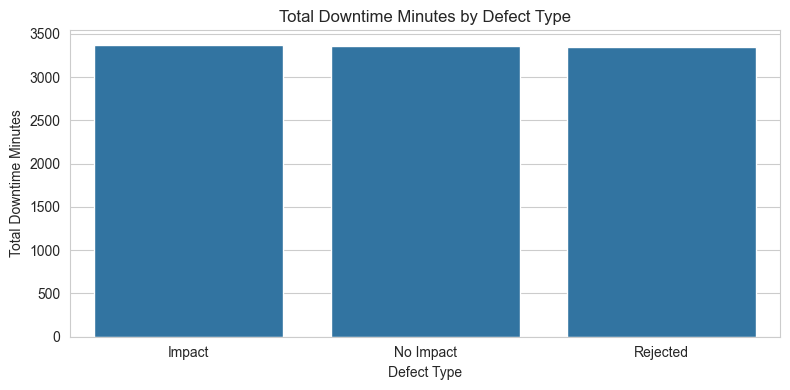

In [25]:
sns.barplot(data=batches, x='Defect Type', y='Total Downtime Minutes', ci=None)
plt.title('Total Downtime Minutes by Defect Type')
plt.xlabel('Defect Type')
plt.ylabel('Total Downtime Minutes')
plt.tight_layout()
plt.show()

- All defect types ("No Impact", "Rejected", "Impact") contribute nearly equally to total downtime minutes.
- No single defect type dominates downtime, indicating that all types require attention for downtime reduction.
- Business action: Downtime improvement initiatives should address all defect areas rather than focusing on just one defect type. Broad, cross-category process optimization will yield the best results.

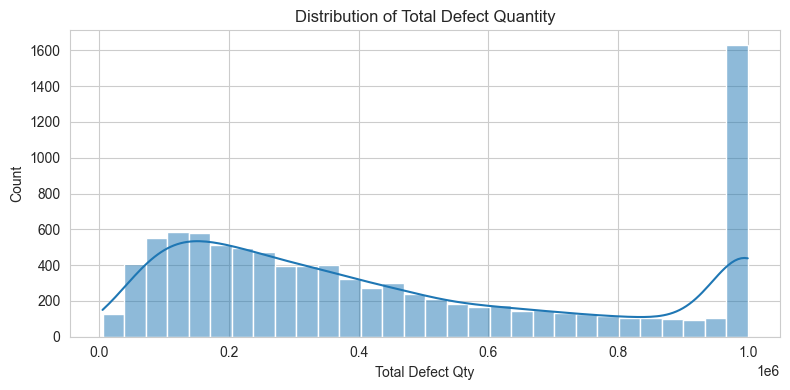

In [26]:
sns.histplot(batches['Total Defect Qty'], bins=30, kde=True)
plt.title('Distribution of Total Defect Quantity')
plt.xlabel('Total Defect Qty')
plt.tight_layout()
plt.show()

- The distribution is heavily right-skewed, showing most defect quantities are moderate, with many cases clustered at low values.
- There is a pronounced spike at the maximum defect quantity (around 1,000,000), indicating a potential data cap or reporting limit in the system.

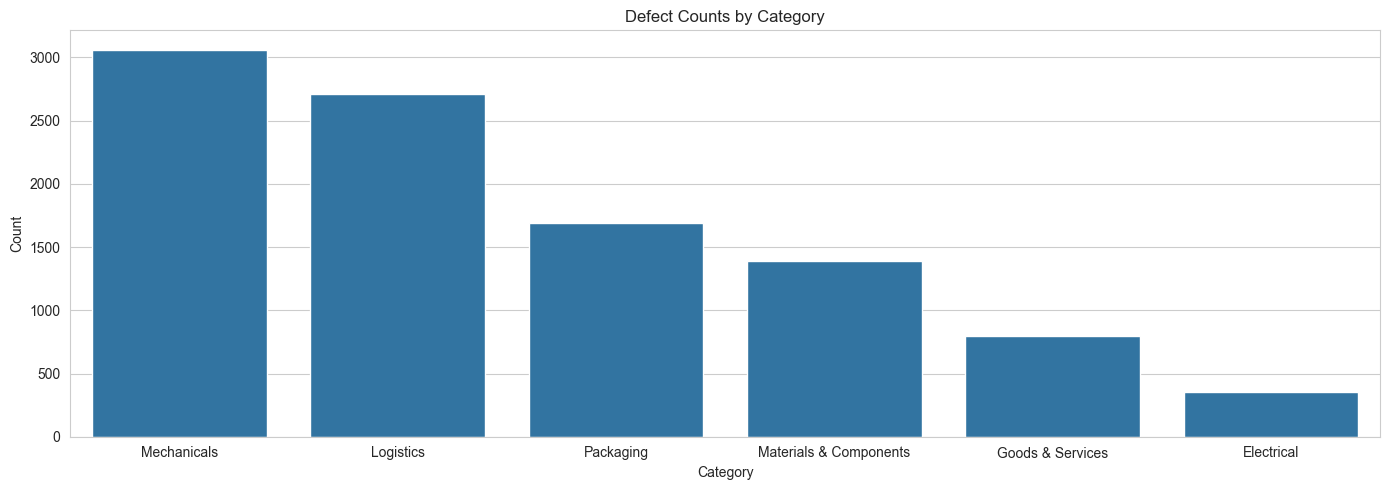

In [27]:
plt.figure(figsize=(14, 5))
sns.countplot(data=batches, x='Category', order=batches['Category'].value_counts().index)
plt.title('Defect Counts by Category')
plt.xlabel('Category')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

- Mechanical and Logistics categories have the highest defect counts, indicating these are the main sources of quality issues.
- Packaging, Materials & Components contribute moderate defects, while Goods & Services and Electrical have the fewest.
- Business action: Focus improvement efforts first on Mechanical and Logistics processes to drive the greatest reduction in overall defects. Maintain ongoing monitoring of other categories to address any emerging issues.

#### **Recommendations:**
- Defects and downtime are common across all batches, plants, and defect types no specific outlier to target.
- Focus first on high-defect plants (like Riverside, Charles City, Twin Rocks) and categories (Mechanical, Logistics) for fastest improvement.
- "Impact" and "Rejected" types, though less frequent, can cause bigger issues tighten controls here.
- Since every defect type contributes to downtime, use company-wide process and maintenance initiatives, not narrow fixes.
- Track all quality patterns regularly and be ready to adapt if new trends emerge.
- Identify any top-performing plants or teams and replicate their successful practices across locations.

This approach maximizes quality gains, reduces risk, and drives efficiency across the entire business.



---



### **Data Cleaning**

In [28]:
batchesCln = batches.copy()

In [29]:
print(batchesCln['Total Defect Qty'].median())
print(batchesCln['Total Downtime Minutes'].median())

360887.0
3627.0


In [30]:
batchesCln['Total Defect Qty'] = batchesCln['Total Defect Qty'].fillna(batchesCln['Total Defect Qty'].median())
batchesCln['Total Downtime Minutes'] = batchesCln['Total Downtime Minutes'].fillna(batchesCln['Total Downtime Minutes'].median())

In [31]:
batchesCln.isnull().sum()

Date                      0
Vendor                    0
Plant Location            0
State                     0
Category                  0
Material Type             0
Defect Type               0
Defect                    0
Total Defect Qty          0
Total Downtime Minutes    0
dtype: int64

In [32]:
batchesCln['Plant Location'].value_counts().sort_index()

Plant Location
Barling           320
Bloomingdale      341
Bruce Crossing    336
Charles City      398
Charlevoix        312
Chatham           311
Chesaning         380
Clarksville       307
Clay              335
Climax            382
Cottonwood        376
De Ruyter         354
Florence          335
Frazer            337
Garwood           339
Henning           336
Hingham           345
Jordan Valley     341
June Lake         324
Middletown        255
New Britain       314
Prescott          336
Reading           280
Ripton            308
Riverside         399
Savannah          306
Twin Rocks        366
Waldoboro         312
Weaverville       312
Westside          303
Name: count, dtype: int64

In [33]:
batchesCln['Category'].value_counts()

Category
Mechanicals               3061
Logistics                 2712
Packaging                 1689
Materials & Components    1391
Goods & Services           797
Electrical                 350
Name: count, dtype: int64

In [34]:
batchesCln['Material Type'].value_counts()

Material Type
Raw Materials        2925
Corrugate            2437
Film                  830
Labels                706
Carton                661
Controllers           556
Batteries             434
Glass                 315
Electrolytes          286
Molds                 259
Composites            226
Hardware              121
Motors                 75
Packaging              63
Drives                 61
Pump                   16
Mechanicals             8
Tape                    8
Crates                  6
Valves                  4
Wires                   2
Printed Materials       1
Name: count, dtype: int64

In [35]:
batchesCln['Defect'].value_counts()

Defect
Not Certified          624
Bad Seams              606
Misc                   514
Foreign Material       401
Warped                 279
                      ... 
Incomplete Tops          1
Assembly Issues          1
Packaging Integrity      1
No Varnish               1
Poor Fit                 1
Name: count, Length: 263, dtype: int64

In [36]:
listDefect = batchesCln['Defect'].unique()

In [37]:
#sort this list
listDefect.sort()
listDefect

array(['Assembly Issues', 'Bad Bearings', 'Bad Bond',
       'Bad Carton Packaging', 'Bad Cut', 'Bad Distribution',
       'Bad Fasteners', 'Bad Fill', 'Bad Film', 'Bad Finish', 'Bad Fit',
       'Bad Flaps', 'Bad Insert', 'Bad Labels', 'Bad Parameters',
       'Bad Print', 'Bad Seal', 'Bad Seams', 'Bad Shots', 'Bad Tiles',
       'Bad Tops', 'Bad Valves', 'Bad Welding', 'Blisters', 'Bowed',
       'Bowed/Warped', 'Broken Glass', 'Broken Valve Seal', 'Bubbling',
       'Burnt', 'Carton Delamination', 'Cartons Not Opening', 'Coating',
       'Codes Wrong', 'Color Deviation', 'Color Variation',
       'Component Failure', 'Components Stuck', 'Container Out of Spec',
       'Contamination', 'Corrugate Falling Apart', 'Crack', 'Cracked',
       'Creases / Wrinkles', 'Crooked', 'Crushed Sidewalls', 'Cut Box',
       'Cut Wires', 'Cuts', 'Damaged', 'Damaged Parts', 'Damaged Rolls',
       'Damaged Secondary Packaging', 'Damaged in Transit', 'Deep Slots',
       'Defective Packaging', 'Defect

In [38]:
def clean_defect_types(defect_series):
    cleaned = defect_series.str.replace(r"[^a-zA-Z0-9/ -]", "", regex=True)
    cleaned = cleaned.str.replace(r"\s*/\s*", "/", regex=True)
    cleaned = cleaned.str.replace(r"\s*-\s*", "-", regex=True)
    cleaned = cleaned.str.strip().str.replace(r"\s+", " ", regex=True)
    cleaned = cleaned.str.replace(r'\s+', ' ', regex=True).str.strip()
    return cleaned

In [39]:
batchesCln['Defect'] = clean_defect_types(batchesCln['Defect'])

In [40]:
batchesCln['Plant Location'] = batchesCln['Plant Location'].str.strip()
batchesCln['Category'] = batchesCln['Category'].str.strip()
batchesCln['Material Type'] = batchesCln['Material Type'].str.strip()
batchesCln['Defect'] = batchesCln['Defect'].str.strip()

In [41]:
batchesCln.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Date                    10000 non-null  datetime64[ns]
 1   Vendor                  10000 non-null  object        
 2   Plant Location          10000 non-null  object        
 3   State                   10000 non-null  object        
 4   Category                10000 non-null  object        
 5   Material Type           10000 non-null  object        
 6   Defect Type             10000 non-null  object        
 7   Defect                  10000 non-null  object        
 8   Total Defect Qty        10000 non-null  float64       
 9   Total Downtime Minutes  10000 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(7)
memory usage: 781.4+ KB




---



In [42]:
batchesCluster = batchesCln.copy()

In [44]:
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans

In [45]:
# Step 1: Prepare the unique defect text data
unique_defects = batchesCluster['Defect'].unique().tolist()
print(f"Found {len(unique_defects)} unique defect descriptions to process.")

Found 262 unique defect descriptions to process.


In [46]:
# Step 2: Generate Text Embeddings
# We use a pre-trained model. 'all-MiniLM-L6-v2' is a great, lightweight choice

print("Loading sentence transformer model and generating embeddings...")
model = SentenceTransformer('all-MiniLM-L6-v2')
defect_embeddings = model.encode(unique_defects, show_progress_bar=True)
print("Embeddings created. Shape:", defect_embeddings.shape)

Loading sentence transformer model and generating embeddings...


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Batches: 100%|██████████| 9/9 [00:00<00:00, 18.47it/s]

Embeddings created. Shape: (262, 384)


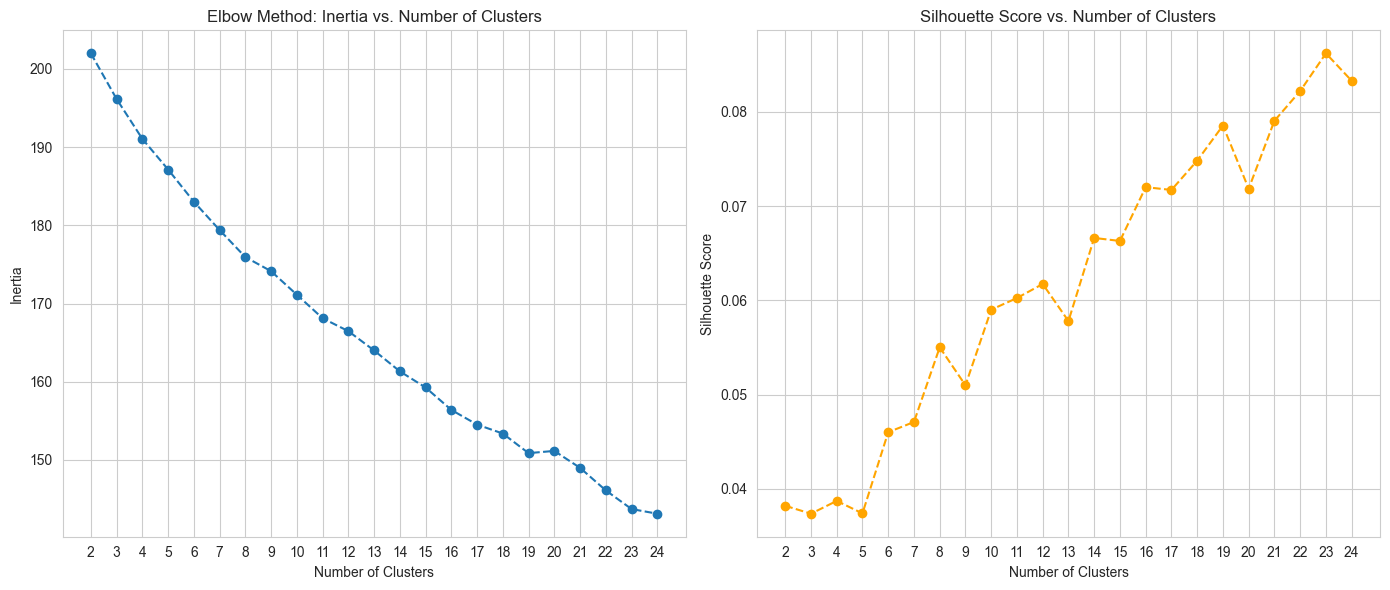

In [111]:
# Assume defect_embeddings is your matrix of embeddings (e.g., output from SentenceTransformer)
k_range = range(2, 25)  # Testing from 2 to 25 clusters

inertia = []
silhouette_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(defect_embeddings)
    inertia.append(kmeans.inertia_)
    score = silhouette_score(defect_embeddings, cluster_labels)
    silhouette_scores.append(score)

# Plotting the results
plt.figure(figsize=(14, 6))

# Elbow plot (Inertia)
plt.subplot(1, 2, 1)
plt.plot(list(k_range), inertia, marker='o', linestyle='--')
plt.title('Elbow Method: Inertia vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.xticks(list(k_range))
plt.grid(True)

# Silhouette Score plot
plt.subplot(1, 2, 2)
plt.plot(list(k_range), silhouette_scores, marker='o', linestyle='--', color='orange')
plt.title('Silhouette Score vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.xticks(list(k_range))
plt.grid(True)

plt.tight_layout()
plt.show()

In [48]:
inertia

[201.9922637939453,
 196.15533447265625,
 191.05764770507812,
 187.14035034179688,
 183.0239715576172,
 179.39820861816406,
 175.9416046142578,
 174.138427734375,
 171.12928771972656,
 168.12107849121094,
 166.47357177734375,
 164.00140380859375,
 161.33261108398438,
 159.2660675048828,
 156.40060424804688,
 154.5236358642578,
 153.37728881835938,
 150.8720703125,
 151.1566925048828,
 148.9912872314453,
 146.1060791015625,
 143.72193908691406,
 143.12782287597656]

In [49]:
silhouette_scores

[0.038197703659534454,
 0.03735635057091713,
 0.03871394693851471,
 0.03739010542631149,
 0.04600529372692108,
 0.047084592282772064,
 0.0550081804394722,
 0.050980500876903534,
 0.05900302156805992,
 0.06023666635155678,
 0.06172696501016617,
 0.0577954463660717,
 0.06661227345466614,
 0.0662926733493805,
 0.07200019061565399,
 0.07170494645833969,
 0.07481078803539276,
 0.07854032516479492,
 0.07183513045310974,
 0.07904445379972458,
 0.08219612389802933,
 0.08619631081819534,
 0.08328498899936676]

- The inertia curve “elbow” is most apparent around 8-10 clusters. After this, the inertia declines slowly and nearly linearly, suggesting no major gain in cohesion from increasing K further.

- Silhouette scores peak progressively with more clusters, but most increases after K=13–15 are marginal, and higher K risks over-fragmentation, making clusters less actionable and possibly too small.

In [50]:
!pip install -q KeyBERT


[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [51]:
from keybert import KeyBERT

# --- Step 1: Run K-Means with Your Chosen K ---
OPTIMAL_K = 8
print(f"Running K-Means with the chosen optimal K = {OPTIMAL_K}")

kmeans = KMeans(n_clusters=OPTIMAL_K, random_state=42, n_init=10)
kmeans.fit(defect_embeddings)

Running K-Means with the chosen optimal K = 8


,n_clusters,8
,init,'k-means++'
,n_init,10
,max_iter,300
,tol,0.0001
,verbose,0
,random_state,42
,copy_x,True
,algorithm,'lloyd'


In [52]:
# Create a mapping from each unique defect description to its cluster ID (0-6)
defect_to_cluster_map = dict(zip(unique_defects, kmeans.labels_))
print("Clustering complete.")


#Step 2: Automatically Generate Cluster Names with KeyBERT
print("\nAutomatically Generating Cluster Names with KeyBERT.....")

# Initialize the KeyBERT model
kw_model = KeyBERT(model='all-MiniLM-L6-v2')

# This dictionary will store our final names, e.g., {0: 'seam_and_seal_issue', 1: 'print_quality_defect', ...}
auto_cluster_names = {}

for i in range(OPTIMAL_K):
    # a. Get all defect descriptions for the current cluster
    cluster_defects = [defect for defect, cluster_id in defect_to_cluster_map.items() if cluster_id == i]

    # b. Join them into a single block of text to be summarized
    document = ". ".join(cluster_defects)

    # c. Extract the best descriptive phrase (1 to 3 words long)
    keywords = kw_model.extract_keywords(document,
                                         keyphrase_ngram_range=(1, 2),
                                         stop_words='english',
                                         top_n=1)

    # d. Get the generated name and clean it up for use as a column name
    if keywords:
        # Replace spaces with underscores and make it lowercase
        cluster_name = keywords[0][0].replace(' ', '_')
    else:
        cluster_name = f"cluster_{i}_unnamed" # Fallback name

    auto_cluster_names[i] = cluster_name

    print(f"Cluster {i}: Suggested Name = '{cluster_name}'")

Clustering complete.

Automatically Generating Cluster Names with KeyBERT.....
Cluster 0: Suggested Name = 'print_defects'
Cluster 1: Suggested Name = 'foreign_material'
Cluster 2: Suggested Name = 'misc_support'
Cluster 3: Suggested Name = 'defective_packaging'
Cluster 4: Suggested Name = 'crease_warped'
Cluster 5: Suggested Name = 'incorrect_color'
Cluster 6: Suggested Name = 'labels_incorrect'
Cluster 7: Suggested Name = 'defects_bad'


In [53]:
#Step 3: Create the Final DataFrame Column
print("\n--- Applying the new names to the DataFrame ---")

# a. First, create the column with the numerical cluster IDs
batchesCluster['Defect_Clusters'] = batchesCluster['Defect'].map(defect_to_cluster_map)

# b. Now, map these IDs to your newly generated names to create the final, human-readable column
batchesCluster['Defect_Category'] = batchesCluster['Defect_Clusters'].map(auto_cluster_names)

# c. Clean up by dropping the intermediate columns
batchesCluster_F = batchesCluster.drop(columns=['Defect_Clusters'])


--- Applying the new names to the DataFrame ---


In [54]:
batchesCluster_F.head()

,Date,Vendor,Plant Location,State,Category,Material Type,Defect Type,Defect,Total Defect Qty,Total Downtime Minutes,Defect_Category
0,2013-04-13,Gabvine,Reading,MN,Logistics,Film,Impact,Damaged Secondary Packaging,326975.0,3252.0,defective_packaging
1,2014-03-12,Linkbridge,Prescott,NY,Packaging,Film,No Impact,Foreign Material,360887.0,2337.0,foreign_material
2,2013-09-28,Realpoint,Florence,IL,Mechanicals,Raw Materials,No Impact,Foreign objects found,82253.0,828.0,foreign_material
3,2013-04-17,Latz,Westside,NC,Logistics,Corrugate,Impact,Gap Variation,189966.0,1935.0,foreign_material
4,2013-03-13,Skiptube,Bruce Crossing,NJ,Goods & Services,Controllers,Rejected,Gap Variation,103577.0,1111.0,foreign_material


In [55]:
batchesCluster_F['Defect_Category'].value_counts()

Defect_Category
foreign_material       2174
misc_support           1958
defects_bad            1728
crease_warped          1405
incorrect_color        1163
defective_packaging     739
print_defects           552
labels_incorrect        281
Name: count, dtype: int64

In [56]:
batchesCluster_F.columns

Index(['Date', 'Vendor', 'Plant Location', 'State', 'Category',
       'Material Type', 'Defect Type', 'Defect', 'Total Defect Qty',
       'Total Downtime Minutes', 'Defect_Category'],
      dtype='object')

In [57]:
batchesCluster_F['Plant Location'].value_counts()

Plant Location
Riverside         399
Charles City      398
Climax            382
Chesaning         380
Cottonwood        376
Twin Rocks        366
De Ruyter         354
Hingham           345
Jordan Valley     341
Bloomingdale      341
Garwood           339
Frazer            337
Bruce Crossing    336
Prescott          336
Henning           336
Clay              335
Florence          335
June Lake         324
Barling           320
New Britain       314
Waldoboro         312
Charlevoix        312
Weaverville       312
Chatham           311
Ripton            308
Clarksville       307
Savannah          306
Westside          303
Reading           280
Middletown        255
Name: count, dtype: int64

In [58]:
batchesCluster_F['State'].value_counts()

State
MI    1787
NY    1256
PA     723
VA     699
MN     364
MA     357
OR     349
IL     340
AR     339
CA     338
NJ     330
MT     325
NC     324
IA     322
OH     316
VT     316
AZ     310
TX     308
ME     307
KY     302
CT     288
Name: count, dtype: int64

In [59]:
# Mapping of states to major U.S. regions
region_map = {
    'CT': 'Northeast', 'ME': 'Northeast', 'MA': 'Northeast', 'NH': 'Northeast',
    'RI': 'Northeast', 'VT': 'Northeast', 'NJ': 'Northeast', 'NY': 'Northeast',
    'PA': 'Northeast',
    'IL': 'Midwest', 'IN': 'Midwest', 'MI': 'Midwest', 'OH': 'Midwest', 'WI': 'Midwest',
    'IA': 'Midwest', 'KS': 'Midwest', 'MN': 'Midwest', 'MO': 'Midwest', 'NE': 'Midwest',
    'ND': 'Midwest', 'SD': 'Midwest',
    'DE': 'South', 'FL': 'South', 'GA': 'South', 'MD': 'South', 'NC': 'South',
    'SC': 'South', 'VA': 'South', 'WV': 'South', 'AL': 'South', 'KY': 'South',
    'MS': 'South', 'TN': 'South', 'AR': 'South', 'LA': 'South', 'OK': 'South',
    'TX': 'South',
    'AZ': 'West', 'CO': 'West', 'ID': 'West', 'MT': 'West', 'NV': 'West', 'NM': 'West',
    'UT': 'West', 'WY': 'West', 'CA': 'West', 'OR': 'West', 'WA': 'West'
}

# Add a new 'Region' column based on the state abbreviation
batchesCluster_F['Region'] = batchesCluster_F['State'].map(region_map)

# Preview the new columns
print(batchesCluster_F[['Plant Location', 'State', 'Region']].head())

   Plant Location State     Region
0         Reading    MN    Midwest
1        Prescott    NY  Northeast
2        Florence    IL    Midwest
3        Westside    NC      South
4  Bruce Crossing    NJ  Northeast


In [60]:
batchesCluster_F['Region'].value_counts()

Region
Northeast    3577
Midwest      3129
South        1972
West         1322
Name: count, dtype: int64

- Reduce Feature Cardinality: Combining plants by state or region lowers the number of unique values, which helps prevent overfitting and reduces model complexity.
- Reveal Regional Trends: Grouping may capture operational or supplier differences by geographical clusters (for example, Midwest vs. West vs. Northeast).
- Support Hierarchical Analysis: You can analyze or predict downtime patterns at multiple levels—plant, state, or region.

In [61]:
batchesCluster_F['Material Type'].value_counts()

Material Type
Raw Materials        2925
Corrugate            2437
Film                  830
Labels                706
Carton                661
Controllers           556
Batteries             434
Glass                 315
Electrolytes          286
Molds                 259
Composites            226
Hardware              121
Motors                 75
Packaging              63
Drives                 61
Pump                   16
Mechanicals             8
Tape                    8
Crates                  6
Valves                  4
Wires                   2
Printed Materials       1
Name: count, dtype: int64

**Clubbing Material Type:**
- Model Stability: Rare material types may lead to less reliable predictions and can cause overfitting if left as separate dummy variables or categories.
- Business Interpretability: Some materials (e.g., “Motors,” “Valves,” “Tape”) are too few to justify independent treatment and do not provide enough statistical power to identify meaningful trends.
- Improves Model Generalization: Reduces noise from rare categories.

In [62]:
# Define a function to group material types into broader categories
def group_material_feature(material):
    electrical_components = ['Controllers', 'Batteries', 'Motors', 'Drives']
    glass_composites = ['Glass', 'Composites', 'Electrolytes', 'Molds']
    packaging_related = ['Packaging', 'Tape', 'Crates', 'Printed Materials', 'Wires']
    other_rare = ['Mechanicals', 'Pump', 'Valves']

    if material in electrical_components:
        return 'Electrical Components'
    elif material in glass_composites:
        return 'Glass/Composites'
    elif material in packaging_related:
        return 'Packaging Related'
    elif material in other_rare:
        return 'Other'
    else:
        return material  # Keep common types like 'Raw Materials', 'Corrugate', etc.

# Apply this function to your actual DataFrame (assumed as df)
batchesCluster_F['Grouped Material Type'] = batchesCluster_F['Material Type'].apply(group_material_feature)

In [63]:
batchesCluster_F['Grouped Material Type'].value_counts()

Grouped Material Type
Raw Materials            2925
Corrugate                2437
Electrical Components    1126
Glass/Composites         1086
Film                      830
Labels                    706
Carton                    661
Hardware                  121
Packaging Related          80
Other                      28
Name: count, dtype: int64

In [64]:
#renaming column name
batchesCluster_F.rename(columns={'Defect Type': 'Defect_Type'}, inplace=True)
batchesCluster_F.rename(columns={'Material Type': 'Material_Type'}, inplace=True)
batchesCluster_F.rename(columns={'Total Defect Qty': 'Total_Defect_Qty'}, inplace=True)
batchesCluster_F.rename(columns={'Total Downtime Minutes': 'Total_Downtime_Minutes'}, inplace=True)
batchesCluster_F.rename(columns={'Plant Location': 'Plant_Location'}, inplace=True)
batchesCluster_F.rename(columns={'Grouped Material Type': 'Grouped_Material_Type'}, inplace=True)

In [65]:
batchesCluster_F.columns

Index(['Date', 'Vendor', 'Plant_Location', 'State', 'Category',
       'Material_Type', 'Defect_Type', 'Defect', 'Total_Defect_Qty',
       'Total_Downtime_Minutes', 'Defect_Category', 'Region',
       'Grouped_Material_Type'],
      dtype='object')

In [66]:
categorical_cols = [
    'Vendor', 'Plant_Location', 'State', 'Category', 'Material_Type', 'Defect_Type', 'Defect', 'Defect_Category', 'Region', 'Grouped_Material_Type']

for col in categorical_cols:
    batchesCluster_F[col] = batchesCluster_F[col].astype('category')

In [67]:
batchesCluster_F['Total_Defect_Qty'] = batchesCluster_F['Total_Defect_Qty'].astype('int64')
batchesCluster_F['Total_Downtime_Minutes'] = batchesCluster_F['Total_Downtime_Minutes'].astype('int64')

In [68]:
batchesCluster_F.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Date                    10000 non-null  datetime64[ns]
 1   Vendor                  10000 non-null  category      
 2   Plant_Location          10000 non-null  category      
 3   State                   10000 non-null  category      
 4   Category                10000 non-null  category      
 5   Material_Type           10000 non-null  category      
 6   Defect_Type             10000 non-null  category      
 7   Defect                  10000 non-null  category      
 8   Total_Defect_Qty        10000 non-null  int64         
 9   Total_Downtime_Minutes  10000 non-null  int64         
 10  Defect_Category         10000 non-null  category      
 11  Region                  10000 non-null  category      
 12  Grouped_Material_Type   10000 non-null  categor



---

Removing unwanted columns: Date, Vendor, Plant_Location, State, Material_Type, Defect

In [69]:
batchesNew = batchesCluster_F.drop(columns=['Date', 'Vendor', 'Plant_Location', 'State', 'Material_Type', 'Defect'])

In [70]:
batchesNew.describe(include='category')

,Category,Defect_Type,Defect_Category,Region,Grouped_Material_Type
count,10000,10000,10000,10000,10000
unique,6,3,8,4,10
top,Mechanicals,No Impact,foreign_material,Northeast,Raw Materials
freq,3061,3978,2174,3577,2925




---



In [71]:
# value_counts of all categorical features datatype
for col in batchesNew.select_dtypes(include='category').columns:
    print(f"Value counts for {col}:")
    print(batchesNew[col].value_counts())
    print("\n")

Value counts for Category:
Category
Mechanicals               3061
Logistics                 2712
Packaging                 1689
Materials & Components    1391
Goods & Services           797
Electrical                 350
Name: count, dtype: int64


Value counts for Defect_Type:
Defect_Type
No Impact    3978
Impact       3271
Rejected     2751
Name: count, dtype: int64


Value counts for Defect_Category:
Defect_Category
foreign_material       2174
misc_support           1958
defects_bad            1728
crease_warped          1405
incorrect_color        1163
defective_packaging     739
print_defects           552
labels_incorrect        281
Name: count, dtype: int64


Value counts for Region:
Region
Northeast    3577
Midwest      3129
South        1972
West         1322
Name: count, dtype: int64


Value counts for Grouped_Material_Type:
Grouped_Material_Type
Raw Materials            2925
Corrugate                2437
Electrical Components    1126
Glass/Composites         1086
Film      

In [72]:
batchesNew.columns

Index(['Category', 'Defect_Type', 'Total_Defect_Qty', 'Total_Downtime_Minutes',
       'Defect_Category', 'Region', 'Grouped_Material_Type'],
      dtype='object')

In [73]:
#correlation for  numerical columns
batchesNew[['Total_Defect_Qty','Total_Downtime_Minutes']].corr(method='pearson')

,Total_Defect_Qty,Total_Downtime_Minutes
Total_Defect_Qty,1.000000,0.849327
Total_Downtime_Minutes,0.849327,1.000000


In [74]:
#correlation for  numerical columns
batchesNew[['Total_Defect_Qty','Total_Downtime_Minutes']].corr(method='spearman')

,Total_Defect_Qty,Total_Downtime_Minutes
Total_Defect_Qty,1.000000,0.937183
Total_Downtime_Minutes,0.937183,1.000000


In [75]:
# Now checking for categorical features

# categorical_cols
target = 'Total_Downtime_Minutes'

results_ = []

for col in batchesNew.select_dtypes(include='category').columns:
  temp_df = batchesNew[[col, target]]
  groups = [group[target].values for name, group in temp_df.groupby(col)]

  f_stat, p_val = stats.f_oneway(*groups)
  results_.append({'Feature': col, 'F-Score': f_stat, 'P-Value': p_val})

# Create and sort results table
anova_df = pd.DataFrame(results_).sort_values(by='P-Value')
print(anova_df)

                 Feature   F-Score   P-Value
4  Grouped_Material_Type  1.917117  0.045012
3                 Region  1.089043  0.352296
0               Category  0.612158  0.690615
1            Defect_Type  0.179958  0.835308
2        Defect_Category  0.384432  0.912014




---




In [76]:
batchesModel = batchesNew.copy()

In [77]:
X = batchesModel.drop('Total_Downtime_Minutes', axis=1)
y = batchesModel['Total_Downtime_Minutes']

# Perform the stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,  # 20% test size
    random_state=42
)

**Defect_Category**
- This column has several sizeable but also some rare categories.
- It is a primary driver of your business question (defects and their impact on downtime).
- Ensures all defect groups are represented during both training and evaluation.

In [78]:
# Check that the stratification was successful
print("Defect_Category distribution in training set:")
print(X_train['Defect_Category'].value_counts(normalize=True))
print("\nDefect_Category distribution in test set:")
print(X_test['Defect_Category'].value_counts(normalize=True))

Defect_Category distribution in training set:
Defect_Category
foreign_material       0.213625
misc_support           0.197375
defects_bad            0.176125
crease_warped          0.140750
incorrect_color        0.117625
defective_packaging    0.073000
print_defects          0.052000
labels_incorrect       0.029500
Name: proportion, dtype: float64

Defect_Category distribution in test set:
Defect_Category
foreign_material       0.2325
misc_support           0.1895
defects_bad            0.1595
crease_warped          0.1395
incorrect_color        0.1110
defective_packaging    0.0775
print_defects          0.0680
labels_incorrect       0.0225
Name: proportion, dtype: float64


In [79]:
X_train.head()

,Category,Defect_Type,Total_Defect_Qty,Defect_Category,Region,Grouped_Material_Type
9254,Materials & Components,No Impact,54577,print_defects,Northeast,Corrugate
1561,Materials & Components,Impact,404458,defects_bad,Midwest,Carton
1670,Logistics,Impact,520004,print_defects,Northeast,Raw Materials
6087,Logistics,Rejected,212679,crease_warped,West,Glass/Composites
6669,Packaging,No Impact,999759,crease_warped,Northeast,Corrugate




---



In [80]:
categorical_features = X_train.select_dtypes(include='category').columns
numerical_features = X_train.select_dtypes(exclude='category').columns

In [81]:
# # Initialize encoder
# encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first')

# # Fit ONLY on training data
# encoder.fit(X_train[categorical_features])

# # Transform both datasets
# X_train_encoded = encoder.transform(X_train[categorical_features])
# X_test_encoded = encoder.transform(X_test[categorical_features])  # uses same mapping as training

In [82]:
X_train_encoded = X_train.drop('Total_Defect_Qty', axis=1)
X_test_encoded = X_test.drop('Total_Defect_Qty', axis=1)

In [83]:
encoders_dict = {}

for names in categorical_features:
    list_label_index = list(X_train[names].value_counts().index)
    len_labels = len(list_label_index)
    dict_encode = {k:v for k,v in zip(list_label_index, range(len_labels))}

    encoders_dict[names] = dict_encode  # Save mapping for this feature

    X_train_encoded[names] = X_train[names].map(dict_encode)
    X_test_encoded[names] = X_test[names].map(dict_encode)

In [84]:
scaler = StandardScaler()
scaler.fit(X_train[numerical_features])     # Fit ONLY on X_train

X_train_num = scaler.transform(X_train[numerical_features])
X_test_num = scaler.transform(X_test[numerical_features])

# Step 4: Combine both parts
X_train_processed = np.hstack([X_train_num, X_train_encoded])
X_test_processed = np.hstack([X_test_num, X_test_encoded])

In [85]:
X_train_processed

array([[-1.25577843,  3.        ,  0.        ,  6.        ,  0.        ,
         1.        ],
       [-0.16082336,  3.        ,  1.        ,  2.        ,  1.        ,
         6.        ],
       [ 0.20077866,  1.        ,  1.        ,  6.        ,  0.        ,
         0.        ],
       ...,
       [-1.08672559,  2.        ,  0.        ,  2.        ,  0.        ,
         0.        ],
       [ 1.70217534,  3.        ,  0.        ,  2.        ,  0.        ,
         4.        ],
       [-0.90315496,  2.        ,  2.        ,  2.        ,  0.        ,
         2.        ]], shape=(8000, 6))

In [86]:
numerical_features

Index(['Total_Defect_Qty'], dtype='object')

In [87]:
X_train_encoded.columns

Index(['Category', 'Defect_Type', 'Defect_Category', 'Region',
       'Grouped_Material_Type'],
      dtype='object')

In [88]:
# Step 1: Get feature names from the encoder
# encoded_cat_feature_names = encoder.get_feature_names_out(categorical_features)

# Step 2: Combine all feature names (scaled numeric + one-hot encoded categorical)
final_feature_names = list(numerical_features) + list(X_train_encoded.columns)

# Step 3: Convert NumPy arrays to DataFrames with proper column names and indices
X_train_final = pd.DataFrame(X_train_processed, columns=final_feature_names, index=X_train_encoded.index)
X_test_final = pd.DataFrame(X_test_processed, columns=final_feature_names, index=X_test_encoded.index)

In [89]:
print(X_train_final.shape)
print(X_test_final.shape)

(8000, 6)
(2000, 6)




---



In [90]:
X_train_final.columns

Index(['Total_Defect_Qty', 'Category', 'Defect_Type', 'Defect_Category',
       'Region', 'Grouped_Material_Type'],
      dtype='object')

In [91]:
X_train_final.head()

,Total_Defect_Qty,Category,Defect_Type,Defect_Category,Region,Grouped_Material_Type
9254,-1.255778,3.0,0.0,6.0,0.0,1.0
1561,-0.160823,3.0,1.0,2.0,1.0,6.0
1670,0.200779,1.0,1.0,6.0,0.0,0.0
6087,-0.760997,1.0,2.0,3.0,3.0,3.0
6669,1.702175,2.0,0.0,3.0,0.0,1.0


In [92]:
# Add constant (intercept) to train and test sets
X_train_ols = sm.add_constant(X_train_final)
X_test_ols = sm.add_constant(X_test_final)

# Fit OLS model on training data
ols_model = sm.OLS(y_train, X_train_ols)
results = ols_model.fit()

# Print model summary
print(results.summary())

# Make predictions
y_train_pred_lr = results.predict(X_train_ols)
y_test_pred_lr = results.predict(X_test_ols)

# Calculate MSE and RMSE for training data
mse_train_lr = mean_squared_error(y_train, y_train_pred_lr)
rmse_train_lr = np.sqrt(mse_train_lr)

# Calculate MSE and RMSE for test data
mse_test_lr = mean_squared_error(y_test, y_test_pred_lr)
rmse_test_lr = np.sqrt(mse_test_lr)

# Output results
print(f"Train MSE: {mse_train_lr:.4f}, RMSE: {rmse_train_lr:.4f}")
print(f"Test MSE: {mse_test_lr:.4f}, RMSE: {rmse_test_lr:.4f}")

                              OLS Regression Results                              
Dep. Variable:     Total_Downtime_Minutes   R-squared:                       0.721
Model:                                OLS   Adj. R-squared:                  0.721
Method:                     Least Squares   F-statistic:                     3442.
Date:                    Fri, 15 Aug 2025   Prob (F-statistic):               0.00
Time:                            11:56:49   Log-Likelihood:                -65159.
No. Observations:                    8000   AIC:                         1.303e+05
Df Residuals:                        7993   BIC:                         1.304e+05
Df Model:                               6                                         
Covariance Type:                nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------

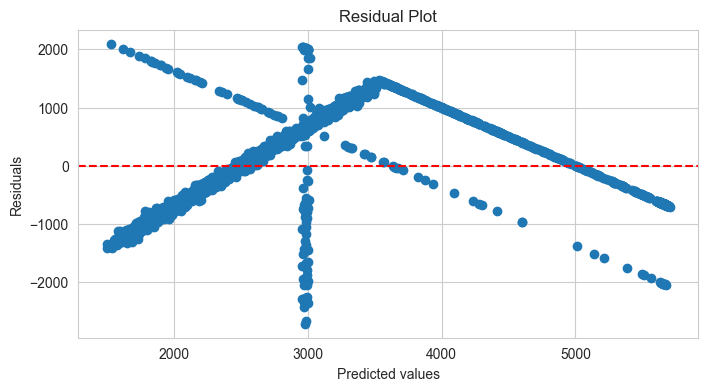

In [93]:
# after fitting your model
residuals = y_test - y_test_pred_lr

# Residual plot
plt.scatter(y_test_pred_lr, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

Linear Regression Doesn't Fit Well

- Non-linear patterns in residuals, model is missing complexity.
- Changing spread of residuals → possible heteroscedasticity.
- Clustered residuals → likely issues with categorical encoding or hidden interactions.

JB Test Result:
- Prob(JB) ≈ 0, Residuals are not normal, another sign linear regression isn't valid here.





---



In [94]:
def evaluate_and_print(model, X_train, y_train, X_test, y_test, name):
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    mae_train = mean_absolute_error(y_train, y_train_pred)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    r2_train = r2_score(y_train, y_train_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    r2_test = r2_score(y_test, y_test_pred)
    print(f"{name} Performance:")
    print(f"Train MAE: {mae_train:.2f}, Train RMSE: {rmse_train:.2f}")
    print(f"Test  MAE: {mae_test:.2f}, Test  RMSE: {rmse_test:.2f}")
    print(f"Train R^2: {r2_train:.2f}")
    print(f"Test  R^2: {r2_test:.2f}\n")

In [95]:
models = [
    ("Decision Tree", DecisionTreeRegressor(random_state=42)),
    ("Random Forest", RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)),
    ("AdaBoost", AdaBoostRegressor(n_estimators=100, random_state=42)),
    ("Gradient Boosting (GBM)", GradientBoostingRegressor(n_estimators=100, random_state=42)),
    ("XGBoost", XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1))
]

In [96]:
#  Pipeline execution (run this block to get all results)
for name, model in models:
    evaluate_and_print(model, X_train_final, y_train, X_test_final, y_test, name)

Decision Tree Performance:
Train MAE: 11.08, Train RMSE: 107.12
Test  MAE: 248.30, Test  RMSE: 690.14
Train R^2: 1.00
Test  R^2: 0.81

Random Forest Performance:
Train MAE: 79.60, Train RMSE: 204.47
Test  MAE: 218.16, Test  RMSE: 528.09
Train R^2: 0.98
Test  R^2: 0.89

AdaBoost Performance:
Train MAE: 323.52, Train RMSE: 511.78
Test  MAE: 336.24, Test  RMSE: 530.12
Train R^2: 0.89
Test  R^2: 0.89

Gradient Boosting (GBM) Performance:
Train MAE: 169.65, Train RMSE: 434.71
Test  MAE: 189.38, Test  RMSE: 484.34
Train R^2: 0.92
Test  R^2: 0.91

XGBoost Performance:
Train MAE: 134.60, Train RMSE: 315.76
Test  MAE: 227.75, Test  RMSE: 525.77
Train R^2: 0.96
Test  R^2: 0.89





---



In [97]:
!pip install -q optuna


[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [98]:
import optuna

**GBM**

In [99]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=100),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
    }
    model_gbm = GradientBoostingRegressor(**params, random_state=42)
    # model.fit(X_train_final, y_train)
    # preds = model.predict(X_test_final)
    # rmse = np.sqrt(mean_squared_error(y_test, preds))
    # return rmse

    # Evaluate with 5-fold cross-validation and return the mean RMSE
    cv_scores = cross_val_score(
        model_gbm,
        X_train_final, y_train,
        cv=5,
        scoring='neg_root_mean_squared_error'
    )
    return -cv_scores.mean()  # Negative because Optuna minimizes; scoring returns negative RMSE

# Optuna study for parameter search
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

[I 2025-08-15 11:57:16,846] A new study created in memory with name: no-name-346b8755-1f21-4242-8b05-2a098e846afd
[I 2025-08-15 11:57:39,820] Trial 0 finished with value: 570.4898045703355 and parameters: {'n_estimators': 1000, 'learning_rate': 0.1337656485736536, 'max_depth': 9, 'subsample': 0.8717666579950667, 'min_samples_split': 4, 'min_samples_leaf': 9, 'max_features': 'sqrt'}. Best is trial 0 with value: 570.4898045703355.
[I 2025-08-15 11:58:28,674] Trial 1 finished with value: 540.066886601104 and parameters: {'n_estimators': 1000, 'learning_rate': 0.03228258833036799, 'max_depth': 10, 'subsample': 0.7942872356983286, 'min_samples_split': 9, 'min_samples_leaf': 7, 'max_features': None}. Best is trial 1 with value: 540.066886601104.
[I 2025-08-15 11:58:57,573] Trial 2 finished with value: 564.6406488109448 and parameters: {'n_estimators': 700, 'learning_rate': 0.0893447893299902, 'max_depth': 7, 'subsample': 0.8148422919920296, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max

In [100]:
# Print the best found parameters
print("Best Parameters:", study.best_params)

# Fit final model with the best parameters
best_params = study.best_params
final_model_gbm = GradientBoostingRegressor(**best_params, random_state=42)
final_model_gbm.fit(X_train_final, y_train)

# Predict for both sets
y_train_pred_gbm = final_model_gbm.predict(X_train_final)
y_test_pred_gbm = final_model_gbm.predict(X_test_final)

# Calculate metrics
mse_train_gbm = mean_squared_error(y_train, y_train_pred_gbm)
rmse_train_gbm = np.sqrt(mean_squared_error(y_train, y_train_pred_gbm))
r2_train_gbm = r2_score(y_train, y_train_pred_gbm)

mse_test_gbm = mean_squared_error(y_test, y_test_pred_gbm)
rmse_test_gbm = np.sqrt(mean_squared_error(y_test, y_test_pred_gbm))
r2_test_gbm = r2_score(y_test, y_test_pred_gbm)

print(f"Train MSE: {mse_train_gbm:.4f}, RMSE: {rmse_train_gbm:.4f}, R²: {r2_train_gbm:.4f}")
print(f"Test  MSE: {mse_test_gbm:.4f}, RMSE: {rmse_test_gbm:.4f}, R²: {r2_test_gbm:.4f}")

Best Parameters: {'n_estimators': 200, 'learning_rate': 0.024813609309159372, 'max_depth': 3, 'subsample': 0.8695063611865217, 'min_samples_split': 3, 'min_samples_leaf': 9, 'max_features': None}
Train MSE: 198994.9343, RMSE: 446.0885, R²: 0.9201
Test  MSE: 232676.9561, RMSE: 482.3660, R²: 0.9078




---



**XGB**

In [101]:
def objective(trial):
    params = {
        'objective': 'reg:squarederror',
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=50),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 10.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0),
        'random_state': 42,
        'verbosity': 0
    }

    model_xgb = XGBRegressor(**params)
    # model.fit(X_train_final, y_train)
    # preds = model.predict(X_test_final)
    # rmse = np.sqrt(mean_squared_error(y_test, preds))
    # return rmse

    # Evaluate with 5-fold cross-validation and return the mean RMSE
    cv_scores = cross_val_score(
        model_xgb,
        X_train_final, y_train,
        cv=5,
        scoring='neg_root_mean_squared_error'
    )
    return -cv_scores.mean()  # Negative because Optuna minimizes; scoring returns negative RMSE

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

print(study.best_params)

[I 2025-08-15 12:07:06,904] A new study created in memory with name: no-name-4ad13b1c-22f3-4187-96c3-65f996caf389
[I 2025-08-15 12:07:11,003] Trial 0 finished with value: 478.9578491210938 and parameters: {'n_estimators': 700, 'learning_rate': 0.0052183395641121665, 'max_depth': 6, 'subsample': 0.9540884679618993, 'colsample_bytree': 0.6935196955121206, 'min_child_weight': 1, 'gamma': 0.7254031923299747, 'reg_alpha': 5.441761575753762, 'reg_lambda': 7.168815075735587}. Best is trial 0 with value: 478.9578491210938.
[I 2025-08-15 12:07:29,075] Trial 1 finished with value: 527.2236999511719 and parameters: {'n_estimators': 900, 'learning_rate': 0.03899588714040239, 'max_depth': 12, 'subsample': 0.566534493661851, 'colsample_bytree': 0.9004541185203961, 'min_child_weight': 6, 'gamma': 0.4570495227477328, 'reg_alpha': 1.9569886273593917, 'reg_lambda': 7.586244913025152}. Best is trial 0 with value: 478.9578491210938.
[I 2025-08-15 12:07:39,601] Trial 2 finished with value: 618.521960449218

{'n_estimators': 850, 'learning_rate': 0.011988680320109682, 'max_depth': 3, 'subsample': 0.9703480250180043, 'colsample_bytree': 0.6217203205997456, 'min_child_weight': 8, 'gamma': 1.5289690306149553, 'reg_alpha': 4.66218063495619, 'reg_lambda': 2.490132845844766}


In [102]:
# Print the best found parameters
print("Best Parameters:", study.best_params)

# Fit final model with the best parameters
best_params = study.best_params
final_model_xgb = XGBRegressor(**best_params, random_state=42)
final_model_xgb.fit(X_train_final, y_train)

# Predict for both sets
y_train_pred_xgb = final_model_xgb.predict(X_train_final)
y_test_pred_xgb = final_model_xgb.predict(X_test_final)

# Calculate metrics
mse_train_xgb = mean_squared_error(y_train, y_train_pred_xgb)
rmse_train_xgb = np.sqrt(mean_squared_error(y_train, y_train_pred_xgb))
r2_train_xgb = r2_score(y_train, y_train_pred_xgb)

mse_test_xgb = mean_squared_error(y_test, y_test_pred_xgb)
rmse_test_xgb = np.sqrt(mean_squared_error(y_test, y_test_pred_xgb))
r2_test_xgb = r2_score(y_test, y_test_pred_xgb)

print(f"Train MSE: {mse_train_xgb:.4f}, RMSE: {rmse_train_xgb:.4f}, R²: {r2_train_xgb:.4f}")
print(f"Test  MSE: {mse_test_xgb:.4f}, RMSE: {rmse_test_xgb:.4f}, R²: {r2_test_xgb:.4f}")

Best Parameters: {'n_estimators': 850, 'learning_rate': 0.011988680320109682, 'max_depth': 3, 'subsample': 0.9703480250180043, 'colsample_bytree': 0.6217203205997456, 'min_child_weight': 8, 'gamma': 1.5289690306149553, 'reg_alpha': 4.66218063495619, 'reg_lambda': 2.490132845844766}
Train MSE: 198214.5156, RMSE: 445.2129, R²: 0.9204
Test  MSE: 232759.8750, RMSE: 482.4519, R²: 0.9078


In [103]:
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [104]:
result_xgb = mape(y_test, y_test_pred_xgb)
accuracy_xgb = 100 - result_xgb
print(f"MAPE for XGBoost: {result_xgb:.2f}%")
print(f"Regression Accuracy XGBoost: {accuracy_xgb:.2f}%")

MAPE for XGBoost: 11.58%
Regression Accuracy XGBoost: 88.42%


In [105]:
importances = final_model_xgb.feature_importances_
features_names = final_model_xgb.feature_names_in_

feat_imp_df = pd.DataFrame({'feature': features_names, 'importance': importances})
feat_imp_df.sort_values(by='importance', ascending=False, inplace=True)

feat_imp_df

,feature,importance
0,Total_Defect_Qty,0.989294
5,Grouped_Material_Type,0.002499
3,Defect_Category,0.002325
4,Region,0.002047
2,Defect_Type,0.001986
1,Category,0.001848




---



In [106]:
np.array(X_test_final.iloc[1451,:])

array([0.22353644, 4.        , 1.        , 5.        , 1.        ,
       2.        ])

In [107]:
final_model_xgb.predict([X_test_final.iloc[1451,:]])

array([4943.55], dtype=float32)

In [108]:
y_test.iloc[1451]

np.int64(5000)

In [109]:
X_test_final.iloc[1451,:]

Total_Defect_Qty         0.223536
Category                 4.000000
Defect_Type              1.000000
Defect_Category          5.000000
Region                   1.000000
Grouped_Material_Type    2.000000
Name: 3889, dtype: float64



---



In [110]:
# import pickle

# # Save both model and scaler together
# with open("final_model_xgb.pkl", "wb") as f:
#     pickle.dump((encoders_dict, scaler, final_model_xgb), f)

# from google.colab import files
# files.download('final_model_xgb.pkl')

## Business Insights & Recommendations

### Key Findings
- **Main Defect Sources**: Mechanicals (27.4%), Logistics (24.3%), Packaging (15.1%), and Materials & Components (12.5%).
- **Top Defect Types**: Foreign Material (19.4%), Misc Support Issues (17.5%), Defects/Bad Quality (15.4%).
- **Material Types at Risk**: Raw Materials (26.8%), Corrugate (22.4%), Electrical Components (10.4%), Glass/Composites (10%).
- **Regional Trends**: Highest defects in Northeast (32.9%) and Midwest (28.8%).

### Defect Impact
- Most defects labeled **No Impact** (35.6%), but Impact (29.3%) and Rejection (24.7%) still significant.
- Even "No Impact" defects cause hidden costs (inspection, rework).

### Model Highlights
- **Algorithm**: XGBoost Regressor  
- **Performance**: Train R² = 0.9199, Test R² = 0.9078, RMSE ≈ 482 → Strong generalization.
- **Feature Importance**: Total_Defect_Qty is the dominant predictor (98.6% importance).

### Business Conclusions
- **Downtime Prediction**: Reliable for operational planning and supplier monitoring.
- **Focus Areas**: Mechanicals, Logistics, Packaging; Raw Materials & Corrugate.
- **Regional Action**: Prioritize quality audits in Northeast & Midwest.

### Recommendations
1. **Supplier Quality**: Engage high-defect suppliers, use scorecards, and track defect severity.
2. **Material Checks**: Tighten inspections for Raw Materials and Corrugate.
3. **Regional Optimization**: Run process capability studies in high-defect regions.
4. **Preventive Analytics**: Integrate model predictions into MES for proactive planning.

**Note**:  
Our predictive model shows that by focusing on reducing total defect quantities especially in mechanical and packaging-related categories, with an emphasis on raw materials and corrugate we can significantly cut downtime and improve supplier quality. Northeast and Midwest regions present the greatest opportunity for quality improvement initiatives. With R² ~0.91, this tool can reliably guide operational planning and supplier negotiations.


# **END**